### References


[FineTuning](https://www.pyimagesearch.com/2019/06/03/fine-tuning-with-keras-and-deep-learning/)

[Transfer Learning](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

Note: I am using <b>ImageDataGenerator</b>  with `flow_from_directory` method by placing all the files in the requried structured folders. 
We can also use `flow_from_dataframe` method..


We have **16 class** classification probelm here 

### Import libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import shutil
import seaborn as sns

import tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

import os
import random as rn
from tqdm import tqdm
from datetime import datetime

from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
# data -->    https://drive.google.com/open?id=1Z4TyI7FcFVEx8qdl4jO9qxvxaqLSqoEu
!wget --header="Host: doc-0k-b8-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.141 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://drive.google.com/" --header="Cookie: AUTH_ko9e2n4pih8o0e6v38lr491tuub9ugjo=17020403249068426867|1610775075000|7o7g97r615fpo9thjt3svvq0iup1o98d" --header="Connection: keep-alive" "https://doc-0k-b8-docs.googleusercontent.com/docs/securesc/ige1qnhp61vsec278b8923arqlfefd58/5bu0fodmjenp0om74oicqscqiuns3n6r/1610775075000/00484516897554883881/17020403249068426867/1Z4TyI7FcFVEx8qdl4jO9qxvxaqLSqoEu?e=download&authuser=0" -c -O 'rvl-cdip.rar'

--2021-01-16 05:32:02--  https://doc-0k-b8-docs.googleusercontent.com/docs/securesc/ige1qnhp61vsec278b8923arqlfefd58/5bu0fodmjenp0om74oicqscqiuns3n6r/1610775075000/00484516897554883881/17020403249068426867/1Z4TyI7FcFVEx8qdl4jO9qxvxaqLSqoEu?e=download&authuser=0
Resolving doc-0k-b8-docs.googleusercontent.com (doc-0k-b8-docs.googleusercontent.com)... 142.250.73.193, 2607:f8b0:4004:829::2001
Connecting to doc-0k-b8-docs.googleusercontent.com (doc-0k-b8-docs.googleusercontent.com)|142.250.73.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/rar]
Saving to: ‘rvl-cdip.rar’

rvl-cdip.rar            [      <=>           ]   4.34G  64.8MB/s    in 85s     

2021-01-16 05:33:28 (52.4 MB/s) - ‘rvl-cdip.rar’ saved [4660541790]



In [1]:
!unrar x "/content/rvl-cdip.rar" "/content/"
# !unrar x "/content/CurlWget570" "/content/"


In [ ]:
# # How to calculate the filesize 
total_bytes = os.path.getsize('/content/rvl-cdip.rar')
print( round(total_bytes/(1024**3),3) ,' GB')

os.remove('/content/rvl-cdip.rar')
print('remoiving .rar file to free up space')


4.34  GB
remoiving .rar file to free up space


In [ ]:
# https://www.tutorialspoint.com/How-to-calculate-a-directory-size-using-Python#:~:text=To%20get%20the%20size%20of,path.

total_size = 0
for path, dirs, files in os.walk('/content/data_final'):
    for f in files:
        fp = os.path.join(path, f)
        total_size += os.path.getsize(fp)

total_size_inGB = round(total_size/(1024**3),3)
print("Directory size: {} GB".format(total_size_inGB) )

Directory size: 5.426 GB


#### labels.csv

### Import data 

In [ ]:
df = pd.read_csv('/content/labels_final.csv')
df.head(2)

,path,label
0,imagesv/v/o/h/voh71d00/509132755+-2755.tif,3
1,imagesl/l/x/t/lxt19d00/502213303.tif,3


In [ ]:
# Adding this file_name feature as it can be useful in the future

df['file_name'] = df['path'].apply(lambda x:x.split('/')[-1])
df.head(2)

,path,label,file_name
0,imagesv/v/o/h/voh71d00/509132755+-2755.tif,3,509132755+-2755.tif
1,imagesl/l/x/t/lxt19d00/502213303.tif,3,502213303.tif


In [ ]:
# df['file_name'].value_counts()
# Note there are same file at diff locations so moving them into final strutured folders may replace them ...

In [ ]:
df['label'].value_counts()

0     3016
13    3007
14    3006
12    3006
3     3005
8     3003
10    3002
9     3002
7     3000
5     2999
15    2996
4     2994
1     2994
2     2993
11    2992
6     2985
Name: label, dtype: int64

It is a balanced dataset


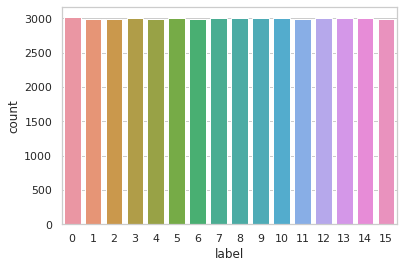

In [ ]:
bar_data  = df['label'].value_counts().reset_index().sort_values(by='index')
bar_data.columns = ['label','count']

#https://seaborn.pydata.org/generated/seaborn.barplot.html
import seaborn as sns
sns.set_theme(style="whitegrid")
# tips = sns.load_dataset("tips")
ax = sns.barplot(x="label", y="count", data = bar_data )

print('It is a balanced dataset')

**Note:**
We have 3000 (approx) images in each class. 
- Considering 1000(approx) images from each class to train the model
- 500(approx) images in each class for validation and 
- 500(aprox) images in each class for test
<pre>Using stratified sampling here </pre>

In [ ]:
X = df[['path','file_name']].values
y = df['label'].values

### Train-Test-Validation split

In [ ]:
from sklearn.model_selection import train_test_split
print(X.shape,y.shape)

# Sampling 2/3 rd of data 32K out of 48K points
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify = y , random_state=42)
print(X_train.shape, X_test.shape)

# Splitiing sampled 32K data into getting --> 16K into train and 16K for (val+test) 
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.5, stratify = y_train , random_state=42)
print(X_train.shape, X_test.shape)

# Spiltting 16K (val+test) into --> 8K validation and 8K test data
X_cv, X_test, y_cv, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify = y_test , random_state=42)
print('\n')
print('STRATIFIED SAMPLING')
print('-------------------')
print(len(X_train),' X_train points',)
print(len(X_cv),' X_cv points',)
print(len(X_test),' X_test points',)

print('Note: After moving files into structured folders we see few decrease in points as there are duplicate files in multiple locations')

(48000, 2) (48000,)
(32160, 2) (15840, 2)
(16080, 2) (16080, 2)


STRATIFIED SAMPLING
-------------------
16080  X_train points
8040  X_cv points
8040  X_test points
Note: After moving files into structured folders we see few decrease in points as there are duplicate files in multiple locations


Checking all tr,cv,test distributions (same or not)

It is a balanced dataset


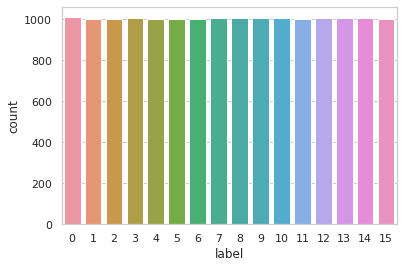

In [ ]:
# checking the distribution X_train points 

arr = np.hstack((X_train,y_train.reshape(-1,1)))
df_train = pd.DataFrame(arr)
df_train.columns = ['path','file_name','label']
df_train.head()

# plottting
bar_data  = df_train['label'].value_counts().reset_index().sort_values(by='index')
bar_data.columns = ['label','count']

#https://seaborn.pydata.org/generated/seaborn.barplot.html
sns.set_theme(style="whitegrid")
# tips = sns.load_dataset("tips")
ax = sns.barplot(x="label", y="count", data = bar_data )

print('It is a balanced dataset')

It is a balanced dataset


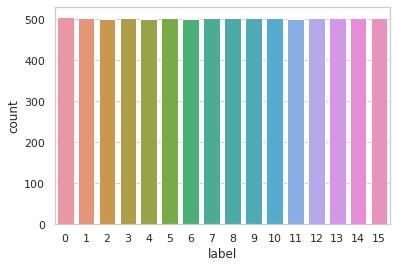

In [ ]:
# checking the distribution X_cv points 

arr = np.hstack((X_cv,y_cv.reshape(-1,1)))
df_cv = pd.DataFrame(arr)
df_cv.columns = ['path','file_name','label']
df_cv.head()

# plottting
bar_data  = df_cv['label'].value_counts().reset_index().sort_values(by='index')
bar_data.columns = ['label','count']

#https://seaborn.pydata.org/generated/seaborn.barplot.html
sns.set_theme(style="whitegrid")
# tips = sns.load_dataset("tips")
ax = sns.barplot(x="label", y="count", data = bar_data )

print('It is a balanced dataset')

It is a balanced dataset


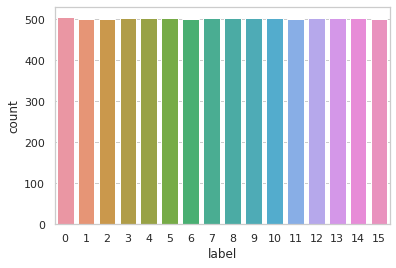

In [ ]:
# checking the distribution X_test points 

arr = np.hstack((X_test,y_test.reshape(-1,1)))
df_test = pd.DataFrame(arr)
df_test.columns = ['path','file_name','label']
df_test.head()

# plottting
bar_data  = df_test['label'].value_counts().reset_index().sort_values(by='index')
bar_data.columns = ['label','count']

#https://seaborn.pydata.org/generated/seaborn.barplot.html
sns.set_theme(style="whitegrid")
# tips = sns.load_dataset("tips")
ax = sns.barplot(x="label", y="count", data = bar_data )

print('It is a balanced dataset')

### Data pipeline

In [ ]:
# All classes are in the below whose index represents labels
classes = ['letter','form','email','handwritten','advertisement',\
            'scientific report','scientific publication','specification','file folder','news article',\
            'budget','invoice','presentation','questionnaire','resume','memo']

# Example:
# class 0 is classes[0] = 'letter'

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
Folder structure

<b>datasets</b>
  |__ <b>train</b>
      |______ <b>letter</b>: [1.tif, 2.tif, 3.tif ....]
      |______ <b>form</b>: [1.tif, 2.tif, 3.tif ....]
      |______ <b>email</b>: [1.tif, 2.tif, 3.tif ....]
      |______ <b>...</b>
  |__ <b>validation</b>
      |______ <b>letter</b>: [1.tif, 2.tif, 3.tif ....]
      |______ <b>form</b>: [1.tif, 2.tif, 3.tif ....]
      |______ <b>email</b>: [1.tif, 2.tif, 3.tif ....]
      |______ <b>...</b>
  |__ <b>test</b>
      |______ <b>letter</b>: [1.tif, 2.tif, 3.tif ....]
      |______ <b>form</b>: [1.tif, 2.tif, 3.tif ....]
      |______ <b>email</b>: [1.tif, 2.tif, 3.tif ....]
      |______ <b>...</b>
</pre>

In [ ]:
# creating all neccessary folders as shown above
base_dir = '/content/datasets'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

if not os.path.exists(base_dir):
  os.makedirs(base_dir)

if not os.path.exists(train_dir): 
  os.makedirs(train_dir)

if not os.path.exists(validation_dir):
  os.makedirs(validation_dir)

if not os.path.exists(test_dir):
  os.makedirs(test_dir)

In [ ]:
df_train.head(1)

,path,file_name,label
0,imagesw/w/a/d/wad14c00/2069728629.tif,2069728629.tif,7


In [ ]:
# creating all 16 classes folder in train,validation and test folders 
for directory in [train_dir,validation_dir,test_dir]:
    for cls in classes:
        req_path = os.path.join(directory,cls)
        if not os.path.exists( req_path ):
            os.makedirs(req_path)
    print('{} folders created in {}'.format( len(os.listdir(directory)), str(directory)) )

16 folders created in /content/datasets/train
16 folders created in /content/datasets/validation
16 folders created in /content/datasets/test


In [ ]:
# Moving all the files from main-directory(data_final) to respective folders
# for dataframe in [df_train,df_cv,df_test]:

for path,filename,label in tqdm(df_train.values):
    source = os.path.join('/content/data_final' ,path )
    destination  = os.path.join(train_dir,classes[label])
    shutil.move(source,destination)

100%|██████████| 16080/16080 [00:00<00:00, 21527.40it/s]


In [ ]:
for path,filename,label in tqdm(df_cv.values):
    source = os.path.join('/content/data_final' ,path )
    destination  = os.path.join(validation_dir,classes[label])
    shutil.move(source,destination)

100%|██████████| 8040/8040 [00:00<00:00, 22220.63it/s]


In [ ]:
for path,filename,label in tqdm(df_test.values):
    source = os.path.join('/content/data_final' ,path )
    destination  = os.path.join(test_dir,classes[label])
    shutil.move(source,destination)

100%|██████████| 8040/8040 [00:00<00:00, 14664.28it/s]


In [ ]:
# counting the files in all train,cv,test folders individually
for directory in [train_dir,validation_dir,test_dir]:
  total = 0
  for path,dirs,files in os.walk(directory):
    for fp in files:
      total+=1
  print('total images in {} :{} '.format(directory,total))

total images in /content/datasets/train :16080 
total images in /content/datasets/validation :8040 
total images in /content/datasets/test :8040 


In [ ]:
## REMOVE files from train directory
# for path,dirs,files in os.walk(directory):
#     for fp in files:
#       remove_path = os.path.join(path,fp)
#       os.remove(remove_path)

### Data Augmentation

Few parts of the code is inspired from AAIC reference.ipynb provided and 
some of the Data Augmentation code is from [Udacity TensorFlow course](https://classroom.udacity.com/courses/ud187/lessons/1771027d-8685-496f-8891-d7786efb71e1/concepts/02685a4f-c874-493b-9772-bf611479740d)


**setting model parameters**

In [ ]:
BATCH_SIZE = 64   # Changing it as I am getting OOM error with 100
IMG_SHAPE  = 224  # Have to resize all the images to 224x224 as the input shape in VGG16 is same

After defining our generators for training and validation images, **flow_from_directory** method will load images from the disk and will apply rescaling and will resize them into required dimensions using single line of code.

In [ ]:
# https://colab.research.google.com/drive/1oySQ1xO_Azpa3X4d1Fs_3_q3avIZCgss#scrollTo=kVoWh4OIVrXD
# Some part of the code inspired from udacity lectures

In [ ]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Flipping the image horizontally

In [ ]:
image_gen = ImageDataGenerator(rescale=1./255 , horizontal_flip=True)
train_data_gen = image_gen.flow_from_directory( directory = train_dir,
                                               batch_size = BATCH_SIZE,
                                               color_mode ='rgb',
                                               target_size = (IMG_SHAPE,IMG_SHAPE),
                                               shuffle = True)

Found 16080 images belonging to 16 classes.


To see the transformation in action, let's take one sample image from our training set and repeat it five times. The augmentation will be randomly applied (or not) to each repetition.

In [ ]:
type(train_data_gen)

tensorflow.python.keras.preprocessing.image.DirectoryIterator

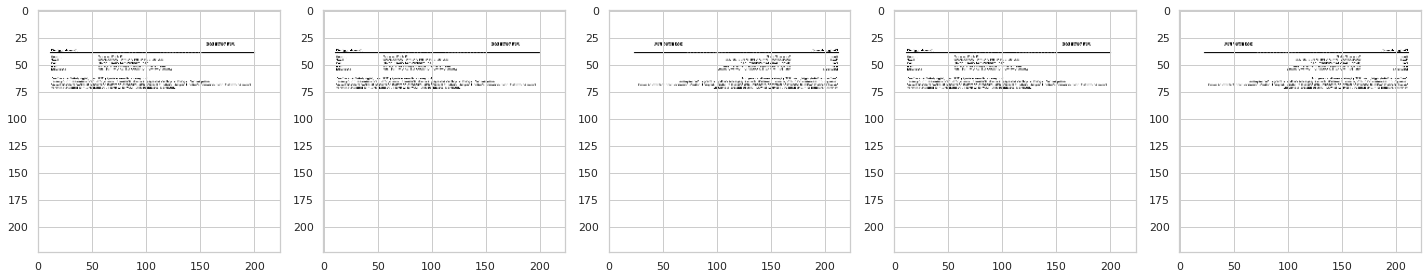

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Rotating the image

In [ ]:
image_gen = ImageDataGenerator(rescale = 1./255 , rotation_range=45) #rotating 45 degrees
train_data_gen = image_gen.flow_from_directory( directory = train_dir,
                                               batch_size = BATCH_SIZE,
                                               color_mode ='rgb',
                                               target_size = (IMG_SHAPE,IMG_SHAPE),
                                               shuffle = True)

Found 16080 images belonging to 16 classes.


To see the transformation in action, let's once again take a sample image from our training set and repeat it. The augmentation will be randomly applied (or not) to each repetition.

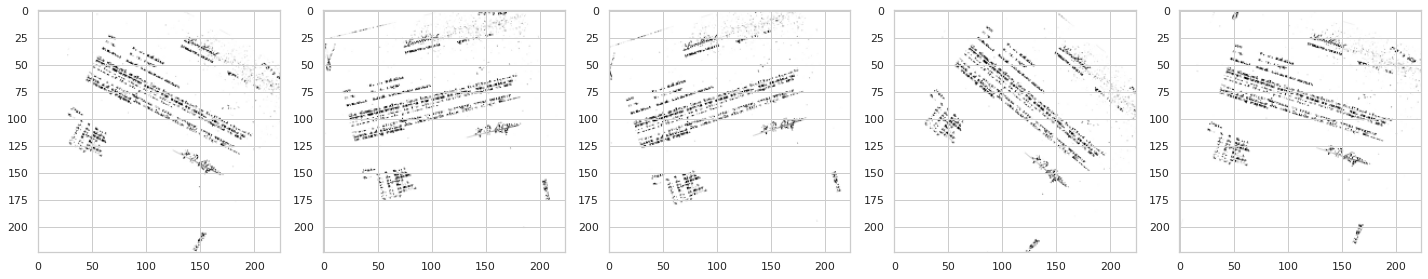

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Creating Train Data generator

### Putting it all together

We can apply all these augmentations, and even others, with just one line of code, by passing the augmentations as arguments with proper values.

Here, we have applied rescale, rotation of 45 degrees, width shift, height shift, horizontal flip, and zoom augmentation to our training images.

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory

image_gen_train = ImageDataGenerator( rescale=1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory( directory = train_dir,
                                               batch_size = BATCH_SIZE,
                                               color_mode ='rgb',
                                               target_size = (IMG_SHAPE,IMG_SHAPE),
                                               shuffle = True,
                                               class_mode='categorical') #use sparse for sparse_categoricalcrossentropy

Found 16080 images belonging to 16 classes.


Let's visualize how a single image would look like five different times, when we pass these augmentations randomly to our dataset. 

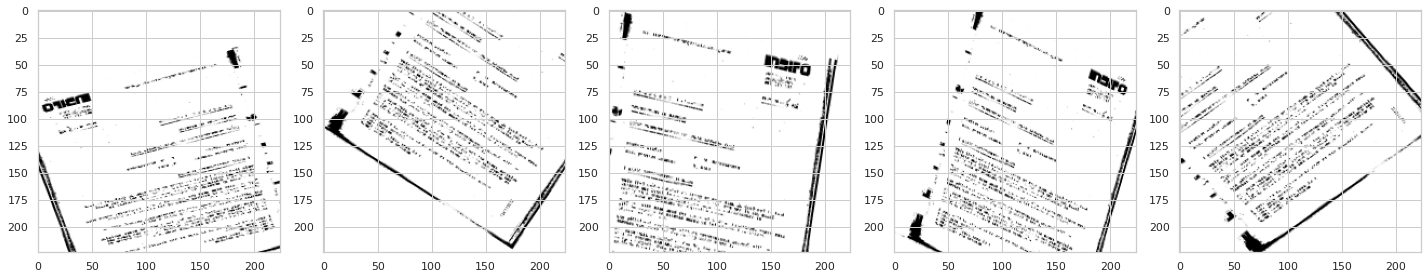

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Creating Validation Data generator

Generally, we only apply data augmentation to our training examples, since the original images should be representative of what our model needs to manage. So, in this case we are only rescaling our validation images and converting them into batches using ImageDataGenerator.

In [ ]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory( directory = validation_dir,
                                               batch_size = BATCH_SIZE,
                                               color_mode ='rgb',
                                               target_size = (IMG_SHAPE,IMG_SHAPE),
                                               shuffle = True,
                                               class_mode='categorical') #use sparse for sparse_categoricalcrossentropy

Found 8040 images belonging to 16 classes.


### Creating Test Data generator

Generally, we only apply data augmentation to our training examples, since the original images should be representative of what our model needs to manage. So, in this case we are only rescaling our test images and converting them into batches using ImageDataGenerator.

In [ ]:
image_gen_test = ImageDataGenerator(rescale=1./255)

test_data_gen = image_gen_test.flow_from_directory( directory = test_dir,
                                               batch_size = BATCH_SIZE,
                                               color_mode ='rgb',
                                               target_size = (IMG_SHAPE,IMG_SHAPE),
                                               shuffle = True,
                                               class_mode='categorical') #use sparse for sparse_categoricalcrossentropy

Found 8040 images belonging to 16 classes.


# Model Creation

## Define the model

The model consists of four convolution blocks with a max pool layer in each of them.

Before the final Dense layers, we're also applying a Dropout probability of 0.5. It means that 50% of the values coming into the Dropout layer will be set to zero. This helps to prevent overfitting.

Then we have a fully connected layer with 512 units, with a `relu` activation function. The model will output class probabilities for two classes — dogs and cats — using `softmax`. 

### regular model without Transfer Learning

In [ ]:
import os
import random as rn

os.environ['PYTHONHASHSEED'] = '0'

##https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
## Set the random seed values to regenerate the model.
np.random.seed(0)
rn.seed(0)

## Have to clear the session. If you are not clearing, Graph will create again and again and graph size will increses. 
## Varibles will also set to some value from before session
tf.keras.backend.clear_session()

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),  #(224,224,3)
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(16, activation ='softmax')
    ])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       1

using train and validation data in `model.fit()` method

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit_generator
# generally model.fit(X_train,y_train)  
# for generators it shud be... model.fit(X_train_gen) <-- read above documentation
# model.fit_generator is deprecated .. and model.fit can be used for generators now

EPOCHS = 2
history = model.fit(train_data_gen,
                    epochs = EPOCHS,
                    batch_size = BATCH_SIZE,
                    validation_data = val_data_gen)

Epoch 1/2
161/161 [==============================] - 256s 2s/step - loss: 2.6798 - accuracy: 0.1285 - val_loss: 2.4382 - val_accuracy: 0.2340
Epoch 2/2
161/161 [==============================] - 254s 2s/step - loss: 2.2861 - accuracy: 0.2703 - val_loss: 2.1174 - val_accuracy: 0.3469


using test data in `model.evaluate()` method for model evaluation

In [ ]:
test_loss,test_accuracy = model.evaluate(test_data_gen)
print('test loss: {}\ntest accuracy: {}'.format(round(test_loss,3),round(test_accuracy,3) ))

81/81 [==============================] - 42s 519ms/step - loss: 2.1083 - accuracy: 0.3464
test loss: 2.108
test accuracy: 0.346


### Transfer Learning 3

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

# Selecting all the layers till last conv block (de-selecting Fully Connected layers)
vgg_model = VGG16(include_top = False, weights='imagenet', input_shape=(224, 224, 3))

# Freezing all layers of original vgg16 model 
for layer in vgg_model.layers[:-6]:
    layer.trainable = False

for layer in vgg_model.layers:
    print('{} is trainable {}'.format(layer.name, layer.trainable))    

input_4 is trainable False
block1_conv1 is trainable False
block1_conv2 is trainable False
block1_pool is trainable False
block2_conv1 is trainable False
block2_conv2 is trainable False
block2_pool is trainable False
block3_conv1 is trainable False
block3_conv2 is trainable False
block3_conv3 is trainable False
block3_pool is trainable False
block4_conv1 is trainable False
block4_conv2 is trainable False
block4_conv3 is trainable True
block4_pool is trainable True
block5_conv1 is trainable True
block5_conv2 is trainable True
block5_conv3 is trainable True
block5_pool is trainable True


In [ ]:
# https://cs231n.github.io/convolutional-networks/#convert
# https://mein2work.medium.com/converting-fc-layers-to-conv-layers-8a43880a44ed#:~:text=Thus%20to%20convert%20an%20FC,equivalent%20to%20a%20FC%20layer

FC_as_Conv1 = Conv2D(filters=4096, kernel_size=(7,7), padding="valid", activation="relu", name = 'FC_as_Conv1') (vgg_model.layers[-1].output)
FC_as_Conv2 = Conv2D(filters=4096, kernel_size=(1,1), padding="valid", activation="relu", name = 'FC_as_Conv2') (FC_as_Conv1)

#Flattening to send this as input to Dense Layer
flat1 = Flatten(data_format='channels_last', name = 'flat1')(FC_as_Conv2)
output = Dense(16, activation ='softmax', name = 'output')(flat1)

#Creating a model
model = tf.keras.Model(inputs=vgg_model.inputs,outputs=output)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

***None in the model represents BATCH_SIZE***

**<pre>This above network is similar to VGG16 except output here 16 classes instead of 1000 classes and #params in last 2 layers is same as VGG though we implemented Dense(FC) layers with Convoluion layers</pre>**

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [ ]:
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/ 

log_dir="/content/drive/MyDrive/Colab Notebooks/fit/model3_" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir , histogram_freq=1, write_graph = True)

# This callback will stop the training when there is no improvement in the validation loss for three consecutive epochs.
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, verbose =1)

callbacks_list = [earlystop_callback,tensorboard_callback]

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
start = datetime.now()

# When we use generators inside model.fit() no need to pass y , check tf documentation for model.fit() 
EPOCHS = 20
history_1 = model.fit(train_data_gen,
                    epochs = EPOCHS,
                    batch_size = BATCH_SIZE,
                    validation_data = val_data_gen,
                    callbacks = callbacks_list)

print('Time taken to run this cell: ',datetime.now()-start)

Epoch 1/20
252/252 [==============================] - 345s 1s/step - loss: 3.0216 - accuracy: 0.0580 - val_loss: 2.7726 - val_accuracy: 0.0626
Epoch 2/20
252/252 [==============================] - 332s 1s/step - loss: 2.7728 - accuracy: 0.0598 - val_loss: 2.7726 - val_accuracy: 0.0627
Epoch 3/20
252/252 [==============================] - 307s 1s/step - loss: 2.7728 - accuracy: 0.0584 - val_loss: 2.7726 - val_accuracy: 0.0628
Epoch 4/20
252/252 [==============================] - 301s 1s/step - loss: 2.7728 - accuracy: 0.0604 - val_loss: 2.7726 - val_accuracy: 0.0628
Epoch 5/20
252/252 [==============================] - 301s 1s/step - loss: 2.7728 - accuracy: 0.0576 - val_loss: 2.7726 - val_accuracy: 0.0627
Epoch 6/20
252/252 [==============================] - 300s 1s/step - loss: 2.7728 - accuracy: 0.0595 - val_loss: 2.7726 - val_accuracy: 0.0627
Epoch 7/20
252/252 [==============================] - 299s 1s/step - loss: 2.7728 - accuracy: 0.0623 - val_loss: 2.7726 - val_accuracy: 0.0628

In [ ]:
test_loss,test_accuracy = model.evaluate(test_data_gen)
print('test loss: {}\ntest accuracy: {}'.format(round(test_loss,3),round(test_accuracy,3) ))

126/126 [==============================] - 48s 377ms/step - loss: 2.7726 - accuracy: 0.0628
test loss: 2.773
test accuracy: 0.063


In [ ]:
# %load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [63]:
# %tensorboard --logdir logs/fit

In [59]:
# !sudo apt install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [62]:
# !unzip /content/logs-20210116T065501Z-001.zip

In [ ]:
# saving model for later use 
# model.save('/content/drive/MyDrive/Colab Notebooks/21 Transfer Learning/my_model2_FC_as_Conv.h5')

In [ ]:
# os.remove('/content/drive/MyDrive/Colab Notebooks/21 Transfer Learning/my_model2_FC_as_Conv.h5')
# print('file removed successfully')

file removed successfully


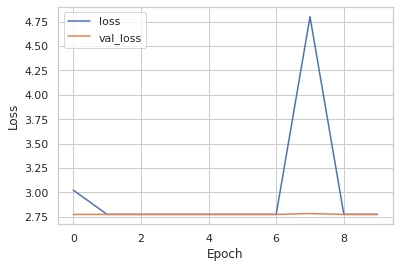

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_1.history['loss'] , label ='loss')
plt.plot(history_1.history['val_loss'], label ='val_loss' )
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## TODO

<pre>
1. Download all the data in this folder 

https://drive.google.com/open?id=1Z4TyI7FcFVEx8qdl4jO9qxvxaqLSqoEu

(Folder) . it contains two file both images and labels. The label file list the images and their categories in the following format:
            <b>path/to/the/image.tif,category</b>
            
    where the categories are numbered 0 to 15, in the following order:

    <b>0 letter
    1 form
    2 email
    3 handwritten
    4 advertisement
    5 scientific report
    6 scientific publication
    7 specification
    8 file folder
    9 news article
    10 budget
    11 invoice
    12 presentation
    13 questionnaire
    14 resume
    15 memo</b>
    
2. On this image data, you have to train 3 types of models as given below. You have to split the data into Train and Validation data.

3. Try not to load all the images into memory, use the generators that we have given in the reference notebooks to load the batch of images only during the train data.
or you can use this method also

<a href='https://medium.com/@vijayabhaskar96/tutorial-on-keras-imagedatagenerator-with-flow-from-dataframe-8bd5776e45c1'>https://medium.com/@vijayabhaskar96/tutorial-on-keras-imagedatagenerator-with-flow-from-dataframe-8bd5776e45c1</a>

<a href='https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c'>https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c</a>


4. You are free to choose Learning rate, optimizer, loss function, image augmentation, any hyperparameters. but you have to use the same architechture what we are asking below. 

5. Use tensorboard for every model and analyse your gradients. (you need to upload the screenshots for each model for evaluation)

Note: fit_genarator() method will have problems with the tensorboard histograms, try to debug it, if you could not do use histgrams=0 i.e don't include histograms, check the documentation of tensorboard for more information. 

6. You can check about Transfer Learning in this link - <a href='https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html'>https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html</a>
</pre>

### Model-1

<pre>
1. Use <a href='https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16'>VGG-16</a> pretrained network without Fully Connected layers and initilize all the weights with Imagenet trained weights. 
2. After VGG-16 network without FC layers, add a new Conv block ( 1 Conv layer and 1 Maxpooling ), 2 FC layers and a output layer to classify 16 classes. You are free to choose any hyperparameters/parameters of conv block, FC layers, output layer. 
3. Final architecture will be <b>INPUT --> VGG-16 without Top layers(FC) --> Conv Layer --> Maxpool Layer --> 2 FC layers --> Output Layer</b>
4. Train only new Conv block, FC layers, output layer. Don't train the VGG-16 network. 

</pre>

**Add callbacks to the model in model.fit()**

In [ ]:
# # https://towardsdatascience.com/a-demonstration-of-transfer-learning-of-vgg-convolutional-neural-network-pre-trained-model-with-c9f5b8b1ab0a
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model
# https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
# https://www.pyimagesearch.com/2019/06/03/fine-tuning-with-keras-and-deep-learning/

In [ ]:
type(tensorflow.keras.applications.vgg16)

module

In [ ]:
tf.keras.backend.clear_session()

**<pre>INPUT --> VGG-16 without Top layers(FC) --> Conv Layer --> Maxpool Layer --> 2 FC layers --> Output Layer</pre>**

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

# Selecting all the layers till last conv block (de-selecting Fully Connected layers)
vgg_model = VGG16(include_top = False, weights='imagenet', input_shape=(224, 224, 3))

# Freezing all layers of original vgg16 model 
for layer in vgg_model.layers:
    layer.trainable = False

# for information look @ reference.ipynb provided 
# https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/
# https://github.com/keras-team/keras/issues/4465

new_conv1 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name = 'new_conv1') (vgg_model.layers[-1].output)
new_pool1 = MaxPooling2D((2,2) , strides = (2,2), name = 'new_pool1') (new_conv1)
flat1 = Flatten(data_format='channels_last', name = 'flat1')(new_pool1)
fc1 = Dense(1024, activation ='relu', name = 'fc1')(flat1)
fc2 = Dense(1024, activation ='relu', name = 'fc2')(fc1)
output = Dense(16, activation ='softmax', name = 'output')(fc2)

#Creating a model
model = tf.keras.Model(inputs=vgg_model.inputs,outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [ ]:
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/ 

log_dir="logs/fit/model1_" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir , histogram_freq=1, write_graph = True)

# This callback will stop the training when there is no improvement in the validation loss for three consecutive epochs.
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose =1)

callbacks_list = [earlystop_callback,tensorboard_callback]

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
start = datetime.now()

# When we use generators inside model.fit() no need to pass y , check tf documentation for model.fit() 
EPOCHS = 20
history_1 = model.fit(train_data_gen,
                    epochs = EPOCHS,
                    batch_size = BATCH_SIZE,
                    validation_data = val_data_gen,
                    callbacks = callbacks_list)

print('Time taken to run this cell: ',datetime.now()-start)

Epoch 1/20
161/161 [==============================] - 279s 2s/step - loss: 2.3790 - accuracy: 0.2669 - val_loss: 1.6696 - val_accuracy: 0.4794
Epoch 2/20
161/161 [==============================] - 274s 2s/step - loss: 1.6735 - accuracy: 0.4668 - val_loss: 1.5226 - val_accuracy: 0.5174
Epoch 3/20
161/161 [==============================] - 274s 2s/step - loss: 1.5170 - accuracy: 0.5204 - val_loss: 1.5167 - val_accuracy: 0.5287
Epoch 4/20
161/161 [==============================] - 273s 2s/step - loss: 1.4772 - accuracy: 0.5300 - val_loss: 1.4204 - val_accuracy: 0.5527
Epoch 5/20
161/161 [==============================] - 274s 2s/step - loss: 1.4076 - accuracy: 0.5594 - val_loss: 1.3939 - val_accuracy: 0.5685
Epoch 6/20
161/161 [==============================] - 275s 2s/step - loss: 1.3720 - accuracy: 0.5665 - val_loss: 1.3333 - val_accuracy: 0.5796
Epoch 7/20
161/161 [==============================] - 273s 2s/step - loss: 1.3388 - accuracy: 0.5738 - val_loss: 1.3588 - val_accuracy: 0.5752

In [ ]:
test_loss,test_accuracy = model.evaluate(test_data_gen)
print('test loss: {}\ntest accuracy: {}'.format(round(test_loss,3),round(test_accuracy,3) ))

81/81 [==============================] - 35s 432ms/step - loss: 1.2948 - accuracy: 0.6014
test loss: 1.295
test accuracy: 0.601


In [ ]:
# saving model for later use 
model.save('/content/drive/MyDrive/Colab Notebooks/21 Transfer Learning/my_model_1.h5')

In [ ]:
# %tensorboard --logdir logs/fit

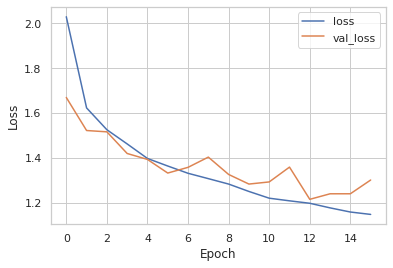

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_1.history['loss'] , label ='loss')
plt.plot(history_1.history['val_loss'], label ='val_loss' )
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model-2

<pre>
1. Use <a href='https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16'>VGG-16</a> pretrained network without Fully Connected layers and initilize all the weights with Imagenet trained weights.
2. After VGG-16 network without FC layers, don't use FC layers, use conv layers only as Fully connected layer. any FC layer can be converted to a CONV layer. This conversion will reduce the No of Trainable parameters in FC layers. For example, an FC layer with K=4096 that is looking at some input volume of size 7×7×512 can be equivalently expressed as a CONV layer with F=7,P=0,S=1,K=4096. In other words, we are setting the filter size to be exactly the size of the input volume, and hence the output will simply be 1×1×4096 since only a single depth column “fits” across the input volume, giving identical result as the initial FC layer. You can refer <a href='http://cs231n.github.io/convolutional-networks/#convert'>this</a> link to better understanding of using Conv layer in place of fully connected layers.
3. Final architecture will be VGG-16 without FC layers(without top), 2 Conv layers identical to FC layers, 1 output layer for 16 class classification. <b>INPUT --> VGG-16 without Top layers(FC) --> 2 Conv Layers identical to FC --> Output Layer</b>
3. Train only last 2 Conv layers identical to FC layers, 1 output layer. Don't train the VGG-16 network. 
</pre>

In [ ]:
# This is more important one ---\
# https://cs231n.github.io/convolutional-networks/#convert

# https://mein2work.medium.com/converting-fc-layers-to-conv-layers-8a43880a44ed#:~:text=Thus%20to%20convert%20an%20FC,equivalent%20to%20a%20FC%20layer.
# https://sebastianraschka.com/faq/docs/fc-to-conv.html

**<pre>INPUT -->VGG-16 without Top layers(FC) --> 2 Conv Layers identical to FC --> Output Layer</pre>**

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

# Selecting all the layers till last conv block (de-selecting Fully Connected layers)
vgg_model = VGG16(include_top = False, weights='imagenet', input_shape=(224, 224, 3))

# Freezing all layers of original vgg16 model 
for layer in vgg_model.layers:
    layer.trainable = False

# https://cs231n.github.io/convolutional-networks/#convert
# https://mein2work.medium.com/converting-fc-layers-to-conv-layers-8a43880a44ed#:~:text=Thus%20to%20convert%20an%20FC,equivalent%20to%20a%20FC%20layer

FC_as_Conv1 = Conv2D(filters=4096, kernel_size=(7,7), padding="valid", activation="relu", name = 'FC_as_Conv1') (vgg_model.layers[-1].output)
FC_as_Conv2 = Conv2D(filters=4096, kernel_size=(1,1), padding="valid", activation="relu", name = 'FC_as_Conv2') (FC_as_Conv1)

#Flattening to send this as input to Dense Layer
flat1 = Flatten(data_format='channels_last', name = 'flat1')(FC_as_Conv2)
output = Dense(16, activation ='softmax', name = 'output')(flat1)

#Creating a model
model = tf.keras.Model(inputs=vgg_model.inputs,outputs=output)
model.summary()


58892288/58889256 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

***None in the model represents BATCH_SIZE***

**<pre>This above network is similar to VGG16 except output here 16 classes instead of 1000 classes and #params in last 2 layers is same as VGG though we implemented Dense(FC) layers with Convoluion layers</pre>**

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [ ]:
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/ 

log_dir="logs/fit/model2_" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir , histogram_freq=1, write_graph = True)

# This callback will stop the training when there is no improvement in the validation loss for three consecutive epochs.
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, verbose =1)

callbacks_list = [earlystop_callback,tensorboard_callback]

In [ ]:
start = datetime.now()

# When we use generators inside model.fit() no need to pass y , check tf documentation for model.fit() 
EPOCHS = 20
history_1 = model.fit(train_data_gen,
                    epochs = EPOCHS,
                    batch_size = BATCH_SIZE,
                    validation_data = val_data_gen,
                    callbacks = callbacks_list)

print('Time taken to run this cell: ',datetime.now()-start)

Epoch 1/20
252/252 [==============================] - 450s 2s/step - loss: 4.3938 - accuracy: 0.2633 - val_loss: 1.7382 - val_accuracy: 0.4389
Epoch 2/20
252/252 [==============================] - 405s 2s/step - loss: 1.7051 - accuracy: 0.4601 - val_loss: 1.5762 - val_accuracy: 0.5144
Epoch 3/20
252/252 [==============================] - 397s 2s/step - loss: 1.5855 - accuracy: 0.4903 - val_loss: 1.4589 - val_accuracy: 0.5356
Epoch 4/20
252/252 [==============================] - 394s 2s/step - loss: 1.5142 - accuracy: 0.5178 - val_loss: 1.5083 - val_accuracy: 0.5296
Epoch 5/20
252/252 [==============================] - 397s 2s/step - loss: 1.4900 - accuracy: 0.5280 - val_loss: 1.4775 - val_accuracy: 0.5430
Epoch 6/20
252/252 [==============================] - 397s 2s/step - loss: 1.4452 - accuracy: 0.5423 - val_loss: 1.3919 - val_accuracy: 0.5777
Epoch 7/20
252/252 [==============================] - 398s 2s/step - loss: 1.4410 - accuracy: 0.5426 - val_loss: 1.4411 - val_accuracy: 0.5551

In [ ]:
test_loss,test_accuracy = model.evaluate(test_data_gen)
print('test loss: {}\ntest accuracy: {}'.format(round(test_loss,3),round(test_accuracy,3) ))

126/126 [==============================] - 89s 703ms/step - loss: 1.2935 - accuracy: 0.6029
test loss: 1.293
test accuracy: 0.603


In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# %tensorboard --logdir logs/fit

In [ ]:
# saving model for later use 
model.save('/content/drive/MyDrive/Colab Notebooks/21 Transfer Learning/my_model2_FC_as_Conv.h5')

In [ ]:
# os.remove('/content/drive/MyDrive/Colab Notebooks/21 Transfer Learning/my_model2_FC_as_Conv.h5')
# print('file removed successfully')

file removed successfully


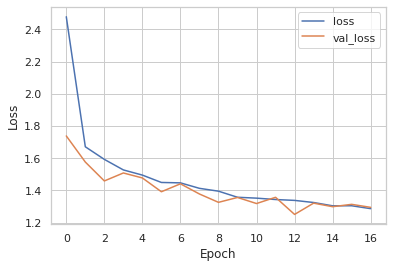

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_1.history['loss'] , label ='loss')
plt.plot(history_1.history['val_loss'], label ='val_loss' )
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model-3

<pre>
1. Use same network as Model-2 '<b>INPUT --> VGG-16 without Top layers(FC) --> 2 Conv Layers identical to FC --> Output Layer</b>' 
and train only Last 6 Layers of VGG-16 network, 2 Conv layers identical to FC layers, 1 output layer.
</pre>

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

# Selecting all the layers till last conv block (de-selecting Fully Connected layers)
vgg_model = VGG16(include_top = False, weights='imagenet', input_shape=(224, 224, 3))

# Freezing all layers of original vgg16 model 
for layer in vgg_model.layers[:-6]:
    layer.trainable = False

for layer in vgg_model.layers:
    print('{} is trainable {}'.format(layer.name, layer.trainable))    

input_4 is trainable False
block1_conv1 is trainable False
block1_conv2 is trainable False
block1_pool is trainable False
block2_conv1 is trainable False
block2_conv2 is trainable False
block2_pool is trainable False
block3_conv1 is trainable False
block3_conv2 is trainable False
block3_conv3 is trainable False
block3_pool is trainable False
block4_conv1 is trainable False
block4_conv2 is trainable False
block4_conv3 is trainable True
block4_pool is trainable True
block5_conv1 is trainable True
block5_conv2 is trainable True
block5_conv3 is trainable True
block5_pool is trainable True


In [ ]:
# https://cs231n.github.io/convolutional-networks/#convert
# https://mein2work.medium.com/converting-fc-layers-to-conv-layers-8a43880a44ed#:~:text=Thus%20to%20convert%20an%20FC,equivalent%20to%20a%20FC%20layer

FC_as_Conv1 = Conv2D(filters=4096, kernel_size=(7,7), padding="valid", activation="relu", name = 'FC_as_Conv1') (vgg_model.layers[-1].output)
FC_as_Conv2 = Conv2D(filters=4096, kernel_size=(1,1), padding="valid", activation="relu", name = 'FC_as_Conv2') (FC_as_Conv1)

#Flattening to send this as input to Dense Layer
flat1 = Flatten(data_format='channels_last', name = 'flat1')(FC_as_Conv2)
output = Dense(16, activation ='softmax', name = 'output')(flat1)

#Creating a model
model = tf.keras.Model(inputs=vgg_model.inputs,outputs=output)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

***None in the model represents BATCH_SIZE***

**<pre>This above network is similar to VGG16 except output here 16 classes instead of 1000 classes and #params in last 2 layers is same as VGG though we implemented Dense(FC) layers with Convoluion layers</pre>**

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [ ]:
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/ 

log_dir="/content/drive/MyDrive/Colab Notebooks/fit/model3_" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir , histogram_freq=1, write_graph = True)

# This callback will stop the training when there is no improvement in the validation loss for three consecutive epochs.
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, verbose =1)

callbacks_list = [earlystop_callback,tensorboard_callback]

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
start = datetime.now()

# When we use generators inside model.fit() no need to pass y , check tf documentation for model.fit() 
EPOCHS = 20
history_1 = model.fit(train_data_gen,
                    epochs = EPOCHS,
                    batch_size = BATCH_SIZE,
                    validation_data = val_data_gen,
                    callbacks = callbacks_list)

print('Time taken to run this cell: ',datetime.now()-start)

Epoch 1/20
252/252 [==============================] - 345s 1s/step - loss: 3.0216 - accuracy: 0.0580 - val_loss: 2.7726 - val_accuracy: 0.0626
Epoch 2/20
252/252 [==============================] - 332s 1s/step - loss: 2.7728 - accuracy: 0.0598 - val_loss: 2.7726 - val_accuracy: 0.0627
Epoch 3/20
252/252 [==============================] - 307s 1s/step - loss: 2.7728 - accuracy: 0.0584 - val_loss: 2.7726 - val_accuracy: 0.0628
Epoch 4/20
252/252 [==============================] - 301s 1s/step - loss: 2.7728 - accuracy: 0.0604 - val_loss: 2.7726 - val_accuracy: 0.0628
Epoch 5/20
252/252 [==============================] - 301s 1s/step - loss: 2.7728 - accuracy: 0.0576 - val_loss: 2.7726 - val_accuracy: 0.0627
Epoch 6/20
252/252 [==============================] - 300s 1s/step - loss: 2.7728 - accuracy: 0.0595 - val_loss: 2.7726 - val_accuracy: 0.0627
Epoch 7/20
252/252 [==============================] - 299s 1s/step - loss: 2.7728 - accuracy: 0.0623 - val_loss: 2.7726 - val_accuracy: 0.0628

In [ ]:
test_loss,test_accuracy = model.evaluate(test_data_gen)
print('test loss: {}\ntest accuracy: {}'.format(round(test_loss,3),round(test_accuracy,3) ))

126/126 [==============================] - 48s 377ms/step - loss: 2.7726 - accuracy: 0.0628
test loss: 2.773
test accuracy: 0.063


In [ ]:
# %load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# %tensorboard --logdir logs/fit

In [ ]:
# !sudo apt install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [ ]:
# !unzip /content/logs-20210116T065501Z-001.zip

In [ ]:
# saving model for later use 
# model.save('/content/drive/MyDrive/Colab Notebooks/21 Transfer Learning/my_model2_FC_as_Conv.h5')

In [ ]:
# os.remove('/content/drive/MyDrive/Colab Notebooks/21 Transfer Learning/my_model2_FC_as_Conv.h5')
# print('file removed successfully')

file removed successfully


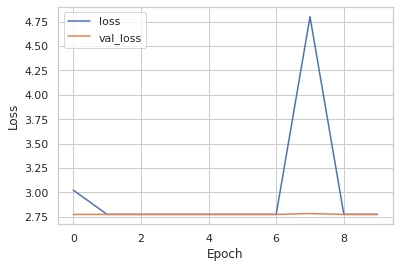

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_1.history['loss'] , label ='loss')
plt.plot(history_1.history['val_loss'], label ='val_loss' )
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()